<a href="https://colab.research.google.com/github/jlopetegui98/Literary-Fine-Tuning-of-LLM/blob/main/ClassifierWildeVsMistral/clf_wild_vs_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classifier Wilde vs Mistral7B (baseline model)

The idea is to train a classifier with texts from Oscar Wilde and texts generated by Mistral7B. Once the model is trained, it should be able to discriminate correctly between texts from both sources. The hypothesis of our work is that after fine tuning the model, we could be able to cheat the classifier.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 86.2 M

In [4]:
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from simpletransformers.classification import ClassificationModel
import torch
import json
import re

In [5]:
# data paths
dir_data = f'./drive/MyDrive/DL-ENS/dataset'
authors_paths = [f'{dir_data}/wilde_complete.txt']
mistral_gen_texts_list = [f'{dir_data}/dataset_mistral7B_gen_texts.json', f'{dir_data}/dataset_mistral7B_gen_texts_2.json']

authors_names = ["Wilde", "Mistral7B"]

In [6]:
# function to read the texts of an specific author
def read_texts(path: str, label, len_to_read =None, max_length = 350):
    text = ''
    with open(path, 'r+') as fd:
      text = fd.read()
      if len_to_read != None:
        text = text[:len_to_read]
    text_splited = text.split()
    dt = {'text': [], 'label': []}
    for i in range(0,len(text_splited),max_length):
      text = ' '.join(text_splited[i:min(i+max_length, len(text_splited))])
      dt['text'].append(text)
      dt['label'].append(label)
    return dt

In [7]:
# get wilde texts
dt = {'text': [], 'label': []}
for i,path in enumerate(authors_paths):
  dt_i = read_texts(path,i)
  dt['text'].extend(dt_i['text'])
  dt['label'].extend(dt_i['label'])

In [8]:
# get mistral generated texts
patt = r'\[INST]|\[\/INST]|\<s>|\</s>|This are the first lines of a work of fiction. Continue it.'
for file in mistral_gen_texts_list:

  with open(file, 'r+') as fd:
    mistral_texts = json.load(fd)

    # clean texts
    mistral_texts_cl = [re.sub(patt, '', x) for x in mistral_texts['texts']]
    dt['text'].extend(mistral_texts_cl)
    dt['label'].extend([1 for _ in range(len(mistral_texts_cl))])

In [9]:
mistral_texts_cl[0]

'  As I turned the corner, I stumbled upon a quaint bookshop that wasn\'t there yesterday.  As I turned the corner, I stumbled upon a quaint bookshop that wasn\'t there yesterday. The storefront was adorned with mismatched lanterns and a colorful display of books that seemed to beckon me inside. Curiosity getting the better of me, I decided to step in and explore.\n\nThe bookshop was small but cozy, with books lining every shelf and stacked on every available surface. There was a distinct musty smell that filled the air, a scent that I instantly identified as belonging to an old book.\n\nAs I browsed through the aisles, I noticed that the titles on the spine of the books weren\'t typical of any bookstore I had ever visited. They were obscure and esoteric, with names like "The Secrets of the Celestial Realms" and "The Art of Transcendence." I couldn\'t help but wonder what lay inside the pages of these mysterious books.\n\nIntrigued, I decided to purchase one of the books and leave with

In [10]:
# convert the dataset to DataFrame
dt = DataFrame.from_dict(dt)
dt.head()

,text,label
0,SOME CRUELTIES OF PRISON LIFE. THE EDITOR OF T...,0
1,"of centralisation, of officialism, and of irre...",0
2,"warders, not unkindly men, were talking to him...",0
3,for the Prevention of Cruelty to Children woul...,0
4,"night, in a lonely dimly-lit cell, and is prey...",0


In [11]:
dt_train, dt_test = train_test_split(dt, test_size=0.2, random_state=42, shuffle=True)

In [12]:
dt_train.head()

,text,label
361,is certainly a very beautiful and touching poe...,0
135,succession of simple and earnest handicraftsme...,0
1831,fascinates. What in other hands would have bee...,0
2341,anger . LORD AUGUSTUS turns away . The other m...,0
1206,"There she seems to have been a great success, ...",0


In [13]:
dt_test.head()

,text,label
1022,influence of the women they married. Archbisho...,0
1398,eyes fixed on the masterpieces of past literat...,0
1234,appointed Decorator to the Queen. About three ...,0
30,a wide field of the mythopœic faculty. This Eu...,0
139,really no necessity for a new law: nothing cou...,0


array([[<Axes: title={'center': 'label'}>]], dtype=object)

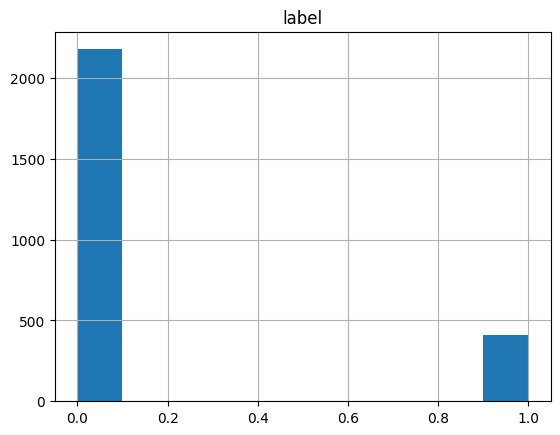

In [14]:
dt_train.hist()

array([[<Axes: title={'center': 'label'}>]], dtype=object)

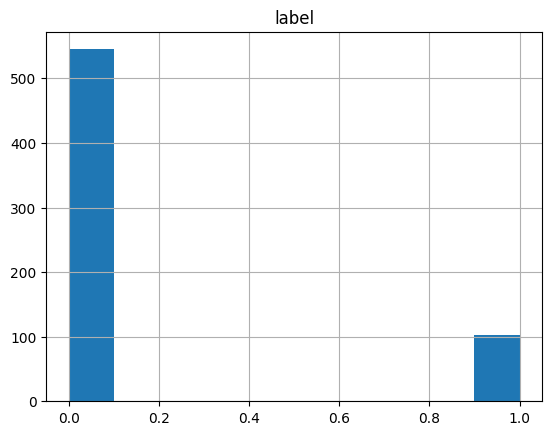

In [15]:
dt_test.hist()

In [16]:
# define model for classifier and initial weights
model_name = 'bert'
model_weights =  'bert-base-cased'

In [17]:
model = ClassificationModel(model_name, model_weights, num_labels=2, weight = [1 - sum(dt_train['label'])/len(dt_train['label']), sum(dt_train['label'])/len(dt_train['label'])], args={'reprocess_input_data': True, 'overwrite_output_dir': True,  'num_train_epochs' : 5}, use_cuda=True)
model.train_model(dt_train)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:611: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2586 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/324 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/324 [00:00<?, ?it/s]

(1620, 0.015152908788425599)

In [18]:
predictions, raw_out = model.predict(list(dt_test['text']))

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [19]:
print(classification_report(dt_test['label'], predictions, target_names = authors_names))

              precision    recall  f1-score   support

       Wilde       1.00      1.00      1.00       545
   Mistral7B       1.00      1.00      1.00       102

    accuracy                           1.00       647
   macro avg       1.00      1.00      1.00       647
weighted avg       1.00      1.00      1.00       647



In [21]:
# save model to drive
model_save_name = 'BertClassifier(BERTAA)_wilde_vs_mistral7Bd_2.pt'
path = f"./drive/My Drive/DL-ENS/{model_save_name}"
torch.save(model, path)